# NYC Parking Tickets: An Exploratory Analysis

New York City is a thriving metropolis. Just like most other metros its size, one of the biggest problems its citizens face is parking. The classic combination of a huge number of cars and cramped geography leads to a huge number of parking tickets. 

In an attempt to scientifically analyse this phenomenon, the NYC Police Department has collected data for parking tickets. Of these, the data files for multiple years are publicly available. it is required to perform some exploratory analysis on a part of this data. Spark will allow us to analyse the full files at high speeds as opposed to taking a series of random samples that will approximate the population. For the scope of this analysis, we will analyse the parking tickets over the year 2017.

The purpose of this case study is to conduct an exploratory data analysis that will help you understand the data. The questions given below will guide your analysis.

In [1]:
## creating a spark session

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("NYC Parking Tickets Case Study") \
    .getOrCreate()

In [2]:
## reading the data

nyc = spark.read.format('csv') \
        .options(header='true', inferschema='true') \
        .load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")

nyc

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

In [3]:
## inspecting few lines of data

nyc.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

In [4]:
## checking the schema for the dataframe

nyc.schema

StructType(List(StructField(Summons Number,LongType,true),StructField(Plate ID,StringType,true),StructField(Registration State,StringType,true),StructField(Issue Date,TimestampType,true),StructField(Violation Code,IntegerType,true),StructField(Vehicle Body Type,StringType,true),StructField(Vehicle Make,StringType,true),StructField(Violation Precinct,IntegerType,true),StructField(Issuer Precinct,IntegerType,true),StructField(Violation Time,StringType,true)))

In [5]:
## printing the schema

nyc.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



In [6]:
## checking overall count

nyc.count()

10803028

In [7]:
## checking distinct count

nyc.distinct().count()

10803028

It shows that there are no duplicates in the file and the dataframe.

In [8]:
## extracting the data for 2017

from pyspark.sql.functions import year

nyc2017 = nyc.filter(year(nyc['Issue Date']) == 2017)
nyc2017.show(5)

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14 00:00:00|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13 00:00:00|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
|    1407740258| 2513JMG|                NY|2017-01-11 00:00:00|            78|             DELV|       FRUEH|               106|            106|         0015A|
|    1413656420|T672371C|         

In [9]:
nyc2017.count()

5431918

The above count shows the total number of records for year 2017.

In [10]:
## extracting data appropriately and creating new columns

from pyspark.sql.functions import col, when
from pyspark.sql.functions import unix_timestamp

## extacting hours, minutes and AM/PM values from Violation Time column
nyc2017 = nyc2017.withColumn("Violation Hour", col("Violation Time").substr(1,2).cast("int"))
nyc2017 = nyc2017.withColumn("Violation Minutes", col("Violation Time").substr(3,2).cast("int"))
nyc2017 = nyc2017.withColumn("Violation ampm", col("Violation Time").substr(5,1))

## converting AM / PM time to absolute hours ranging from 1-24
## here we are adding 12 to pm values provided the time is not between 12 and 13 (12:00 pm to 1:00 pm)
nyc2017 = nyc2017.withColumn("Violation Hour",when(col("Violation Hour")==12,when(col("Violation ampm")=='A',0).otherwise(12)) \
                             .otherwise(when(col("Violation ampm")=='P', col("Violation Hour")+12) \
                                        .otherwise(col("Violation Hour"))))

## creating the unix timestamp using date and time wchich can be used later
nyc2017 = nyc2017.withColumn("Long Time", unix_timestamp(nyc2017["Issue Date"])+ \
                             (nyc2017["Violation Hour"]*3600) + (nyc2017["Violation Minutes"]*60))

## converting Issue Date columns from timestamp to date to use it in future as date
nyc2017 = nyc2017.withColumn("Issue Date", col("Issue Date").cast("date"))

## after extracting the information the these columns are not required and hence dropped
nyc2017 = nyc2017.drop("Violation Time","Violation ampm")

## printing the schema now
nyc2017.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: date (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Hour: integer (nullable = true)
 |-- Violation Minutes: integer (nullable = true)
 |-- Long Time: long (nullable = true)



### Data validation and cleaning

In [11]:
## checking max min Violation hours we computed in dataframe

from pyspark.sql.functions import min, max

nyc2017.select(max("Violation Hour"), min("Violation Hour")).show()

+-------------------+-------------------+
|max(Violation Hour)|min(Violation Hour)|
+-------------------+-------------------+
|                 99|                  0|
+-------------------+-------------------+



In [12]:
## checking count of incorrect Violation hours which are greater than or equal to 24

nyc2017.filter(col("Violation Hour")>=24).count()

55

In [13]:
## checking the count of records before dropping eror records

nyc2017.count()

5431918

In [14]:
## removing incorrect values of Violation Hour (which are quiet less in number than overall count) from dataframe

nyc2017 = nyc2017.filter(col("Violation Hour")<24)
nyc2017.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Hour|Violation Minutes| Long Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|            11|               20|1497439200|
|    5096917368| FZD8593|                NY|2017-06-13|             7|             SUBN|       ME/BE|                 0|              0|            20|               52|1497387120|
|    1407740258| 2513JMG|                NY|2017-01-11|            78|             DELV|       

In [15]:
## checking the record counts after deleting  error records for Violation Hour

nyc2017.count()

5431847

In [16]:
## checking max min Violation hours we computed in dataframe

nyc2017.select(max("Violation Minutes"), min("Violation Minutes")).show()

+----------------------+----------------------+
|max(Violation Minutes)|min(Violation Minutes)|
+----------------------+----------------------+
|                    59|                     0|
+----------------------+----------------------+



In [17]:
## checking for null values count

from pyspark.sql.functions import isnan, count

nyc2017.select([count(when(col(c).isNull(), c)).alias(c) for c in nyc2017.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Hour|Violation Minutes|Long Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+
|             0|       0|                 0|         0|             0|                0|           0|                 0|              0|             0|               13|       13|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+



In [18]:
## dropping the null values (their count is very less)

nyc2017 = nyc2017.na.drop()
nyc2017.count()

5431834

In [19]:
## getting the count for the 'NA' values 

nyc2017.select([count(when(col(c)=='NA', c)).alias(c) for c in nyc2017.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Hour|Violation Minutes|Long Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+
|             0|       0|                 0|         0|             0|                0|           0|                 0|              0|             0|                0|        0|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+---------+



## Examine the data

### Find the total number of tickets for the year.

In [20]:
## checking the count for tickets (we already know that records are distinct)
## after initial data analysis and removing null data records

nyc2017.count()

5431834

Total number of tickets for 2017 are 5431834. This number is obtained after some (very less) number of records were removed due to error in data due to null values. Initially the number of records were 5431918.

### Find out the number of unique states from where the cars that got parking tickets came. 

There is a numeric entry '99' in the column, which should be corrected. Replace it with the state having the maximum entries. Provide the number of unique states again.

In [21]:
## extracting distinct Registration State

from pyspark.sql.functions import countDistinct

nyc2017.select(countDistinct(col("Registration State"))).collect()

[Row(count(DISTINCT Registration State)=65)]

In [22]:
## checking ticket counts across states

nyc2017_ticket_across_states = nyc2017.select("Registration State").groupBy("Registration State") \
                                    .count().sort("count",ascending=False)

nyc2017_ticket_across_states.collect()

[Row(Registration State='NY', count=4273883),
 Row(Registration State='NJ', count=475821),
 Row(Registration State='PA', count=140284),
 Row(Registration State='CT', count=70403),
 Row(Registration State='FL', count=69464),
 Row(Registration State='IN', count=45524),
 Row(Registration State='MA', count=38941),
 Row(Registration State='VA', count=34366),
 Row(Registration State='MD', count=30211),
 Row(Registration State='NC', count=27152),
 Row(Registration State='TX', count=18827),
 Row(Registration State='IL', count=18666),
 Row(Registration State='GA', count=17537),
 Row(Registration State='99', count=16054),
 Row(Registration State='AZ', count=12379),
 Row(Registration State='OH', count=12281),
 Row(Registration State='CA', count=12153),
 Row(Registration State='ME', count=10806),
 Row(Registration State='SC', count=10395),
 Row(Registration State='MN', count=10083),
 Row(Registration State='OK', count=9088),
 Row(Registration State='TN', count=8513),
 Row(Registration State='DE', 

From the above command we observed that the Registration State 99 which is errored contain 16054 records.

In [23]:
## replacing the Registration state having '99' value with 'NY' state (state with max entries)

nyc2017 = nyc2017.withColumn("Registration State",when(nyc2017["Registration State"]=='99','NY') \
                             .otherwise(nyc2017["Registration State"]))

## again extracting distinct Registration State
nyc2017.select(countDistinct(col("Registration State"))).collect()

[Row(count(DISTINCT Registration State)=64)]

Initial number of distinct states obtained were 65 of which one was errored(with value 0). The error values were replaced with most frequent state 'NY' and then the count of distinct states was reduced to 64.

#### Let's plot ticket counts across registration states to check the distribution now after data correction

In [24]:
## To plot data first we need to create a data frame with Registration State and count
import pandas as pd
nyc2017_ticket_across_states = nyc2017.select("Registration State").groupBy("Registration State") \
                                    .count().sort("count",ascending=False)
pdDF = nyc2017_ticket_across_states.toPandas()
pdDF.head()

,Registration State,count
0,NY,4289937
1,NJ,475821
2,PA,140284
3,CT,70403
4,FL,69464


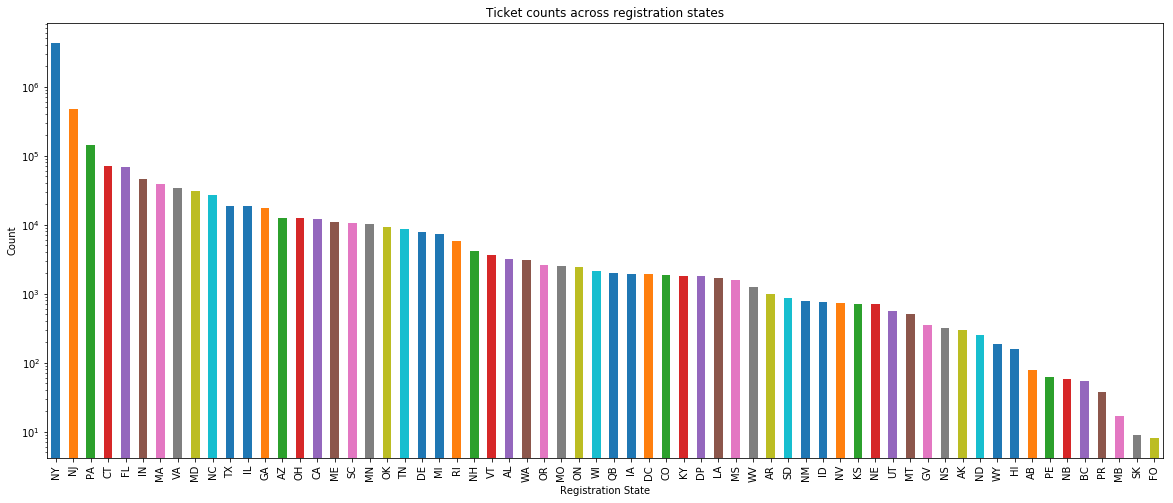

In [28]:
## plot to show distribution of ticket counts across top 5 different states
import matplotlib.pyplot as plt
pdDF.plot(x='Registration State',y='count',kind='bar',figsize=(20, 8),legend=None)
plt.yscale('log')
plt.xlabel('Registration State')
plt.ylabel('Count')
plt.title('Ticket counts across registration states')
plt.show()

## Aggregation tasks

### How often does each violation code occur? Display the frequency of the top five violation codes.

In [29]:
## register dataframe to temp table

nyc2017.createOrReplaceTempView("NYC2017")

In [30]:
## extracting the most frequent violation code along with their annual count

nyc2017_violation_code_count = spark.sql("SELECT \
                                                 `Violation Code`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            GROUP BY \
                                                 `Violation Code`\
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 5 violation codes

nyc2017_violation_code_count.show(5)

+--------------+------------------+
|Violation Code|frequency_per_year|
+--------------+------------------+
|            21|            768056|
|            36|            662765|
|            38|            542078|
|            14|            476663|
|            20|            319644|
+--------------+------------------+
only showing top 5 rows



Top five violation codes are 21, 36, 38, 14, 20. Their frequency per year are mentioned above.

#### Plot to see frequency of top 5 violation code across year

<Figure size 432x288 with 0 Axes>

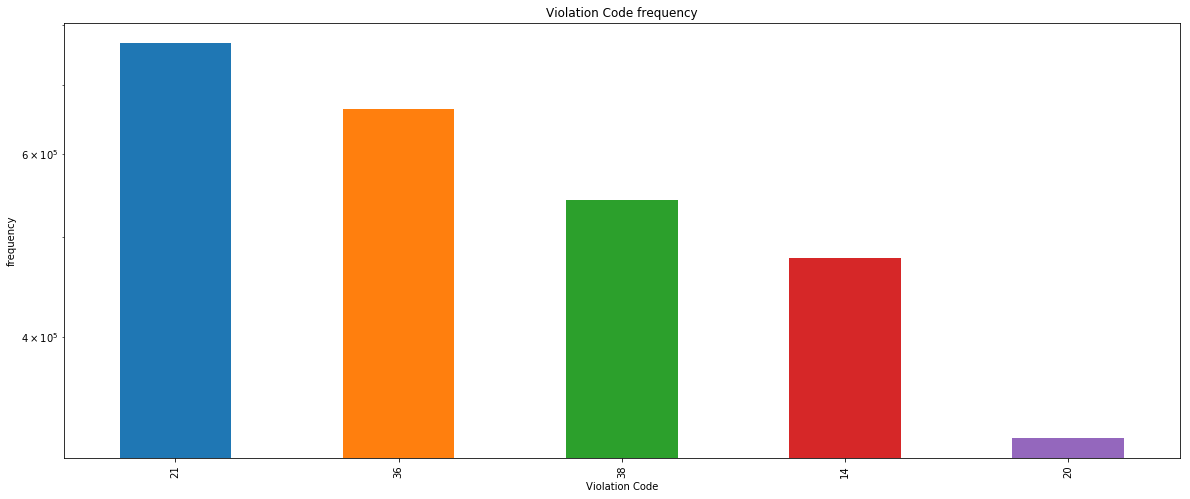

In [31]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_violation_code_count.toPandas()

## plot to show distribution of ticket counts across different states
plt.clf()
pdDF[0:5].plot(x='Violation Code',y='frequency_per_year',kind='bar',figsize=(20, 8),legend=None)
plt.yscale('log')
plt.xlabel('Violation Code')
plt.ylabel('frequency')
plt.title('Violation Code frequency')
plt.show()

### How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? 

In [32]:
## extracting the most frequent Vehicle Body Type along with annual count

nyc2017_vehicle_body_type_count = spark.sql("SELECT \
                                                 `Vehicle Body Type`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            GROUP BY \
                                                 `Vehicle Body Type`\
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 5 Vehicle Body Type

nyc2017_vehicle_body_type_count.show(5)

+-----------------+------------------+
|Vehicle Body Type|frequency_per_year|
+-----------------+------------------+
|             SUBN|           1883925|
|             4DSD|           1547312|
|              VAN|            724025|
|             DELV|            358980|
|              SDN|            194164|
+-----------------+------------------+
only showing top 5 rows



Top five Vehicle Body Type are SUBN, 4DSD, VAN, DELV, SDN. Their frequencies are mentioned above.

In [33]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_vehicle_body_type_count.toPandas()

pdDF.count()

Vehicle Body Type     1165
frequency_per_year    1165
dtype: int64

<Figure size 432x288 with 0 Axes>

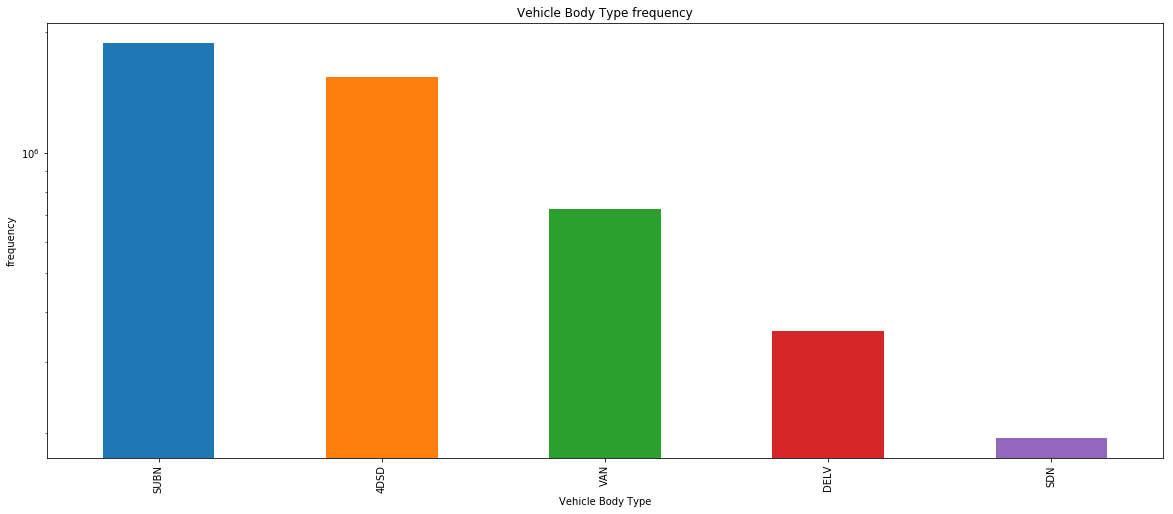

In [34]:
## plot to show distribution of ticket counts across top 5 vehicle body
plt.clf()
pdDF[0:5].plot(x='Vehicle Body Type',y='frequency_per_year',kind='bar',figsize=(20, 8),legend=None)
plt.yscale('log')
plt.xlabel('Vehicle Body Type')
plt.ylabel('frequency')
plt.title('Vehicle Body Type frequency')
plt.show()

In [35]:
## extracting the most frequent Vehicle Make along with annual count

nyc2017_vehicle_make_count = spark.sql("SELECT \
                                                 `Vehicle Make`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            GROUP BY \
                                                 `Vehicle Make`\
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 5 Vehicle Make

nyc2017_vehicle_make_count.show(5)

+------------+------------------+
|Vehicle Make|frequency_per_year|
+------------+------------------+
|        FORD|            636839|
|       TOYOT|            605283|
|       HONDA|            538874|
|       NISSA|            462006|
|       CHEVR|            356026|
+------------+------------------+
only showing top 5 rows



Top five Vehicle Make are FORD, TOYOT, HONDA, NISSA, CHEVR. Their frequencies per year are mentioned above.

<Figure size 432x288 with 0 Axes>

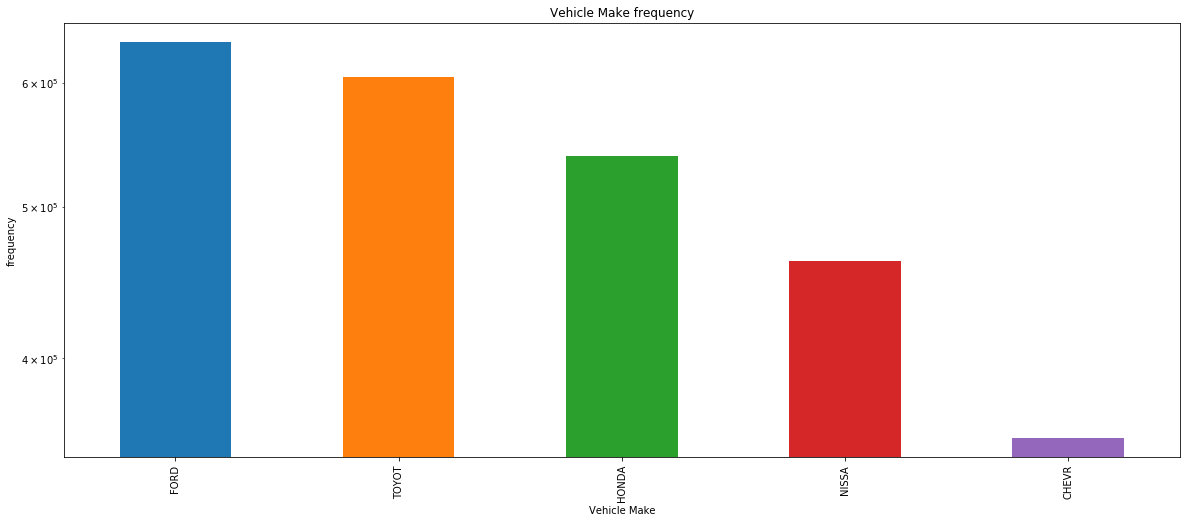

In [36]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_vehicle_make_count.toPandas()
## plot to show distribution of ticket counts across top 5 Vehicle Make
plt.clf()
pdDF[0:5].plot(x='Vehicle Make',y='frequency_per_year',kind='bar',figsize=(20, 8),legend=None)
plt.yscale('log')
plt.xlabel('Vehicle Make')
plt.ylabel('frequency')
plt.title('Vehicle Make frequency')
plt.show()

### A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:

- 'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?

- 'Issuer Precinct' (This is the precinct that issued the ticket.)

Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts.

In [37]:
## extracting the most frequent Violation Precinct along with annual count
## excluding the errored entries

nyc2017_vehicle_make_count = spark.sql("SELECT \
                                                 `Violation Precinct`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            WHERE \
                                                 `Violation Precinct`!=0 \
                                            GROUP BY \
                                                 `Violation Precinct`\
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 5 Violation Precinct

nyc2017_vehicle_make_count.show(5)

+------------------+------------------+
|Violation Precinct|frequency_per_year|
+------------------+------------------+
|                19|            274442|
|                14|            203553|
|                 1|            174701|
|                18|            169130|
|               114|            147442|
+------------------+------------------+
only showing top 5 rows



Top five Violation Precinct are 19, 14, 1, 18, 114. Their frequencies per year are mentioned above. 

<Figure size 432x288 with 0 Axes>

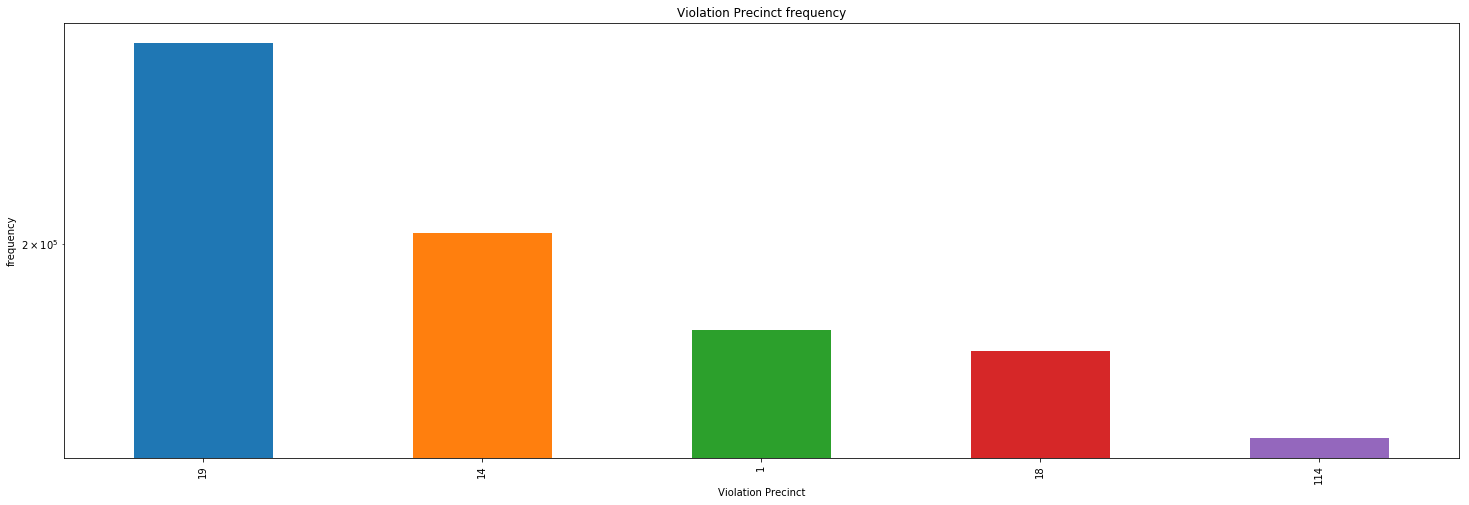

In [38]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_vehicle_make_count.toPandas()
## plot to show distribution of ticket counts across top 5 Violation Precinct
plt.clf()
pdDF[0:5].plot(x='Violation Precinct',y='frequency_per_year',kind='bar',figsize=(25, 8),legend=None)
plt.yscale('log')
plt.xlabel('Violation Precinct')
plt.ylabel('frequency')
plt.title('Violation Precinct frequency')
plt.show()

In [39]:
## extracting the most frequent Issuer Precinct along with annual count
## excluding the errored entries

nyc2017_vehicle_make_count = spark.sql("SELECT \
                                                 `Issuer Precinct`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            WHERE \
                                                 `Issuer Precinct`!=0 \
                                            GROUP BY \
                                                 `Issuer Precinct`\
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 5 Issuer Precinct

nyc2017_vehicle_make_count.show(5)

+---------------+------------------+
|Issuer Precinct|frequency_per_year|
+---------------+------------------+
|             19|            266961|
|             14|            200495|
|              1|            168740|
|             18|            162994|
|            114|            144053|
+---------------+------------------+
only showing top 5 rows



Top five Issuer Precinct are 19, 14, 1, 18, 114. Their frequencies per year are mentioned above. 

<Figure size 432x288 with 0 Axes>

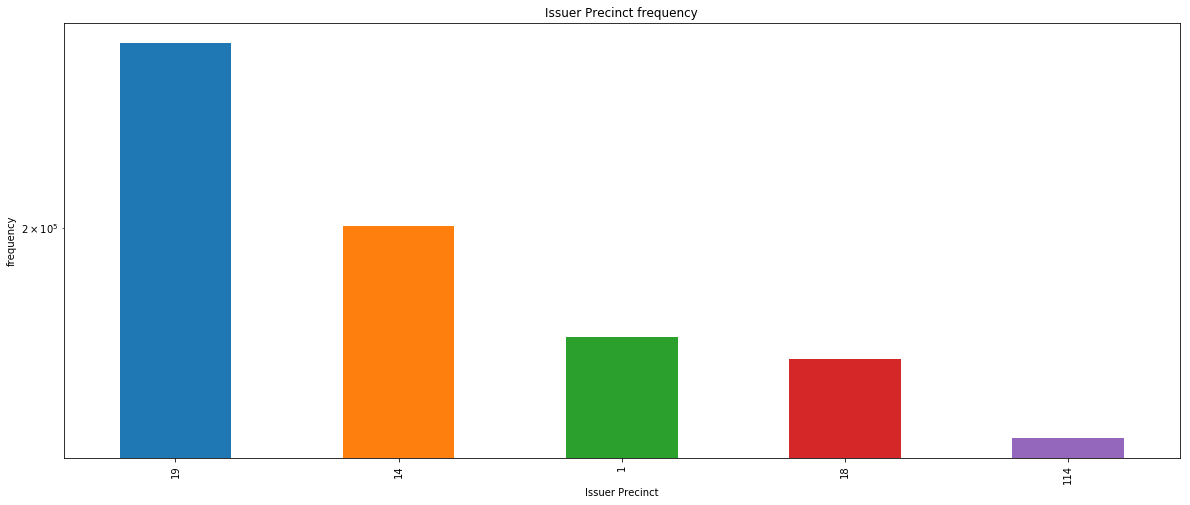

In [40]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_vehicle_make_count.toPandas()
## plot to show distribution of ticket counts across top 5 Issuer Precinct
plt.clf()
pdDF[0:5].plot(x='Issuer Precinct',y='frequency_per_year',kind='bar',figsize=(20, 8),legend=None)
plt.yscale('log')
plt.xlabel('Issuer Precinct')
plt.ylabel('frequency')
plt.title('Issuer Precinct frequency')
plt.show()

### Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts? 

We carry out this in two steps. In the first step, we create a sql view with freqencies grouped by with Issuer Precinct and Violation Code. In second step we use the dense rank function with partition over Issuer Precinct to get the top 5 ranks which are the top five violation codes along with their frequencies.

In [41]:
## evaluating the different Violation Code freqiuencies for top 3 Issuer Precinct

nyc2017_issuer_violation_code_count = spark.sql("SELECT \
                                                 `Issuer Precinct`, \
                                                 `Violation Code`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            WHERE \
                                                 `Issuer Precinct` IN (19,14,1) \
                                            GROUP BY \
                                                 `Issuer Precinct`,`Violation Code` \
                                             ORDER BY \
                                                 frequency_per_year DESC")


## displaying the top 20 frequencies based on grouping of Issuer Precinct and Violation Code

nyc2017_issuer_violation_code_count.show(20)

+---------------+--------------+------------------+
|Issuer Precinct|Violation Code|frequency_per_year|
+---------------+--------------+------------------+
|             19|            46|             48445|
|             14|            14|             45036|
|              1|            14|             38354|
|             19|            38|             36386|
|             19|            37|             36056|
|             14|            69|             30464|
|             19|            14|             29797|
|             19|            21|             28415|
|             14|            31|             22555|
|              1|            16|             19081|
|             14|            47|             18364|
|              1|            20|             15408|
|             19|            20|             14629|
|              1|            46|             12745|
|             19|            40|             11416|
|             14|            42|             10027|
|           

Step 2 taking input as step 1 performed above.

In [42]:
## evaluating the top 5 violation codes for all the top three Issuer Precinct

## creating a temp view from the dataframe crated in above step

nyc2017_issuer_violation_code_count.createOrReplaceTempView("NYC2017_ISSUER_VIOLATION_CODE_COUNT")

## evaluating top 5 based on dense rank

nyc_all_violation_per_precinct_top5 = spark.sql("SELECT \
                                                        `Issuer Precinct`,\
                                                        `Violation Code`, \
                                                        frequency_per_year,\
                                                        rank_top5\
                                                FROM ( \
                                                        SELECT \
                                                                `Issuer Precinct`,\
                                                                `Violation Code`, \
                                                                frequency_per_year, \
                                                                dense_rank() OVER(PARTITION BY `Issuer Precinct` \
                                                                        ORDER BY frequency_per_year DESC) AS rank_top5  \
                                                        FROM \
                                                                NYC2017_ISSUER_VIOLATION_CODE_COUNT \
                                                    )  \
                                                WHERE rank_top5 <= 5")

nyc_all_violation_per_precinct_top5.show()

+---------------+--------------+------------------+---------+
|Issuer Precinct|Violation Code|frequency_per_year|rank_top5|
+---------------+--------------+------------------+---------+
|              1|            14|             38354|        1|
|              1|            16|             19081|        2|
|              1|            20|             15408|        3|
|              1|            46|             12745|        4|
|              1|            38|              8535|        5|
|             19|            46|             48445|        1|
|             19|            38|             36386|        2|
|             19|            37|             36056|        3|
|             19|            14|             29797|        4|
|             19|            21|             28415|        5|
|             14|            14|             45036|        1|
|             14|            69|             30464|        2|
|             14|            31|             22555|        3|
|       

Top 3 Issuer Precinct are 1, 19, 14. From these most frequent violation codes were obtained as above. Violation code 14 exist in top 5 violation for all three Issuer Precinct 1, 19 and 14. However, violation codes 46 and 38 exist in top 5 for both 1 and 19 Issuer Precinct.

<Figure size 432x288 with 0 Axes>

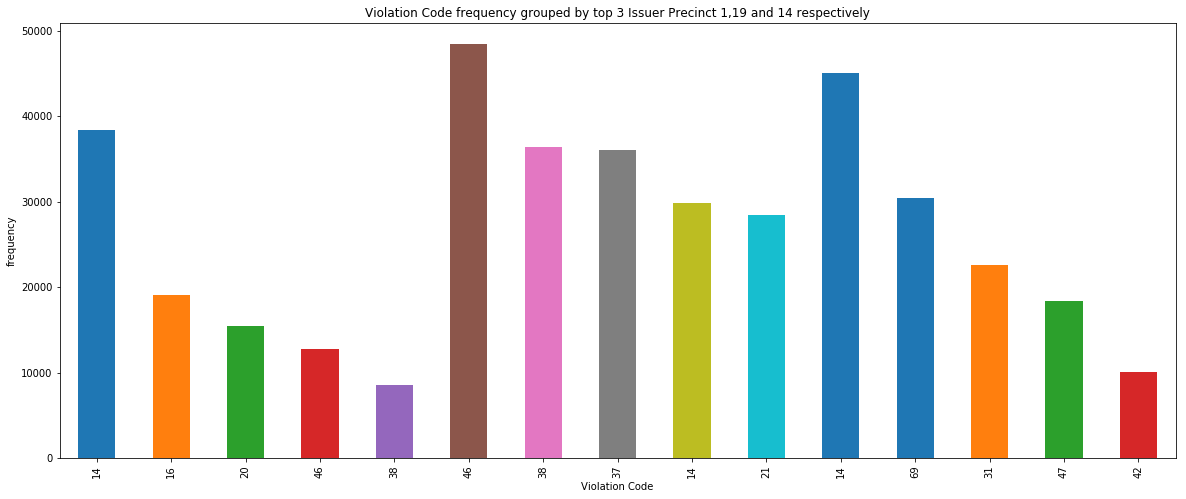

In [45]:
## To plot data first we need to create a data frame 
pdDF = nyc_all_violation_per_precinct_top5.toPandas()
## plot to show distribution of ticket counts across different states
plt.clf()
pdDF.plot(x='Violation Code',y='frequency_per_year',kind='bar',figsize=(20, 8),legend=None)
#plt.yscale('log')
plt.xlabel('Violation Code')
plt.ylabel('frequency')
plt.title('Violation Code frequency grouped by top 3 Issuer Precinct 1,19 and 14 respectively')

plt.show()

### Find out the properties of parking violations across different times of the day:

- Find a way to deal with missing values, if any.

- The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

- Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.

- Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).

In [46]:
## We have extracted the hour information into new column Violation Hour as part of data cleaning.

## We have also already removed the missing values which were quiet less in number
## let us re-confirm that there are no missing values for Violation Hour

nyc2017.filter(col("Violation Hour").isNull()).count()

0

In [47]:
## bucketing on basis of Violation Hour

from pyspark.ml.feature import Bucketizer

## creating bucket borders to divide 24 hours into  6 buckets
hoursBucketBorders = [0,4,8,12,16,20,24]
hoursBucket = Bucketizer().setSplits(hoursBucketBorders).setInputCol("Violation Hour").setOutputCol("Violation Hour Bucket")
nyc2017 = hoursBucket.transform(nyc2017)

nyc2017.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+---------------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Hour|Violation Minutes| Long Time|Violation Hour Bucket|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+---------------------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|            11|               20|1497439200|                  2.0|
|    5096917368| FZD8593|                NY|2017-06-13|             7|             SUBN|       ME/BE|                 0|              0|            20|               52|1497387120|        

In [48]:
## refresh dataframe to temp table so as to take up new column created in dataframe

nyc2017.createOrReplaceTempView("NYC2017")

In [49]:
## evaulating  frequncies across each bucket interval

nyc2017_violation_hour_bucket_count = spark.sql("SELECT \
                                                    `Violation Hour Bucket`, \
                                                     count(*) as frequency_per_year \
                                            FROM \
                                                     NYC2017 \
                                            GROUP BY \
                                                    `Violation Hour Bucket` \
                                             ORDER BY \
                                                 frequency_per_year DESC")



nyc2017_violation_hour_bucket_count.show()

+---------------------+------------------+
|Violation Hour Bucket|frequency_per_year|
+---------------------+------------------+
|                  2.0|           2163563|
|                  3.0|           1839957|
|                  4.0|            637539|
|                  1.0|            449882|
|                  5.0|            176358|
|                  0.0|            164535|
+---------------------+------------------+



Based on the Validation hour timings, the buckets have been created for a 4 hour interval starting from 0 to 24. The frequencies for each buchet are mentioned above. Most of the violations occur in bucjet 2 duration i.e. between 8 hours to 12 hours in the day.

<Figure size 432x288 with 0 Axes>

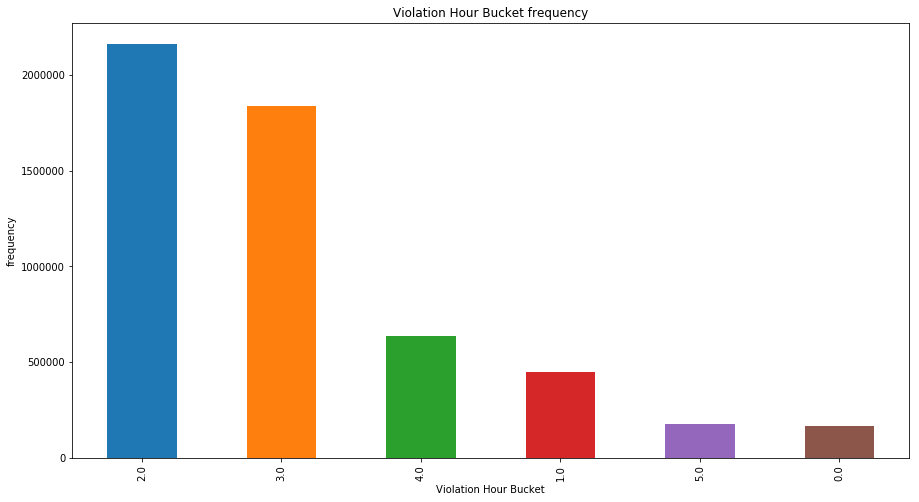

In [50]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_violation_hour_bucket_count.toPandas()
## plot to show distribution of ticket counts across different states
plt.clf()
pdDF.plot(x='Violation Hour Bucket',y='frequency_per_year',kind='bar',figsize=(15, 8),legend=None)
plt.xlabel('Violation Hour Bucket')
plt.ylabel('frequency')
plt.title('Violation Hour Bucket frequency')
plt.show()

In [51]:
## evaulating top 3 violation code across all the buckets

## first grouping the data based on bucket and Violation Code

nyc2017_bucket_violation_code_group = spark.sql("SELECT \
                                                 `Violation Hour Bucket`, \
                                                 `Violation Code`, \
                                                 count(*) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            GROUP BY \
                                                 `Violation Hour Bucket`,`Violation Code`")

## creating a sql temp view
nyc2017_bucket_violation_code_group.createOrReplaceTempView("NYC2017_BUCKET_VIOLATION_CODE_GROUP")

                                                
## finally evauluating top3 violation code for each bucket                                                
nyc2017_bucket_violation_code_top3 = spark.sql("SELECT \
                                                        `Violation Hour Bucket`,\
                                                        `Violation Code`, \
                                                        frequency_per_year,\
                                                        rank_top3\
                                                FROM ( \
                                                        SELECT \
                                                                `Violation Hour Bucket`,\
                                                                `Violation Code`, \
                                                                frequency_per_year, \
                                                                dense_rank() OVER(PARTITION BY `Violation Hour Bucket` \
                                                                        ORDER BY frequency_per_year DESC) AS rank_top3  \
                                                        FROM \
                                                                NYC2017_BUCKET_VIOLATION_CODE_GROUP \
                                                    )  \
                                                WHERE rank_top3 <= 3")
                                    
nyc2017_bucket_violation_code_top3.show()

+---------------------+--------------+------------------+---------+
|Violation Hour Bucket|Violation Code|frequency_per_year|rank_top3|
+---------------------+--------------+------------------+---------+
|                  0.0|            21|             36958|        1|
|                  0.0|            40|             25867|        2|
|                  0.0|            78|             15528|        3|
|                  1.0|            14|             74114|        1|
|                  1.0|            40|             60652|        2|
|                  1.0|            21|             57895|        3|
|                  4.0|            38|            102855|        1|
|                  4.0|            14|             75902|        2|
|                  4.0|            37|             70345|        3|
|                  3.0|            36|            286284|        1|
|                  3.0|            38|            240721|        2|
|                  3.0|            37|          

Top 3 violations occuring across each bucket interval for Violation hours along with their frequencies are mentioned above.

<Figure size 432x288 with 0 Axes>

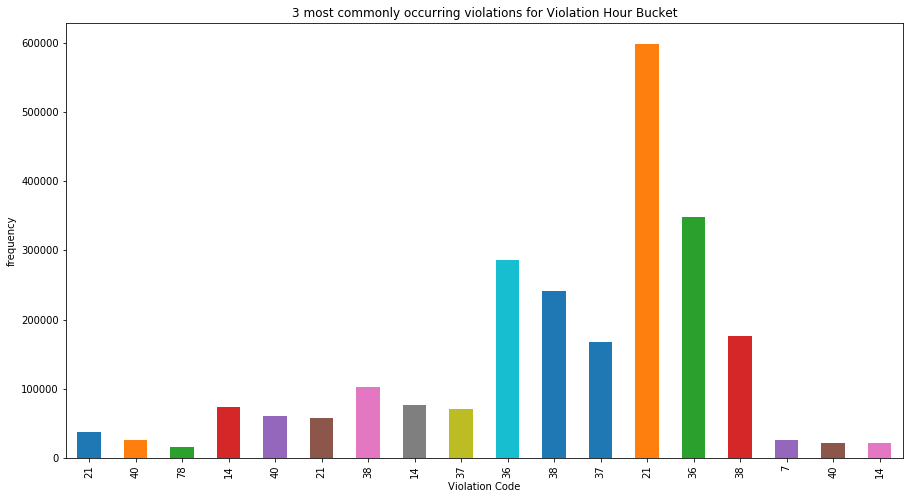

In [52]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_bucket_violation_code_top3.toPandas()
## plot to show distribution of ticket counts across different states
plt.clf()
pdDF.plot(x='Violation Code',y='frequency_per_year',kind='bar',figsize=(15, 8),legend=None)
plt.xlabel('Violation Code')
plt.ylabel('frequency')
plt.title('3 most commonly occurring violations for Violation Hour Bucket')
plt.show()

In [53]:
## now the other way round . finding the most bucket hours frequency for most common 3 violations (21,36,38)

## we'll be using the same sql view NYC2017_BUCKET_VIOLATION_CODE_GROUP we created in above step

## finally evauluating top3 buckets for each violation code

nyc2017_bucket_violation_code_top3 = spark.sql("SELECT \
                                                        `Violation Code`,\
                                                         frequency_per_year, \
                                                         `Violation Hour Bucket`\
                                                FROM \
                                                        NYC2017_BUCKET_VIOLATION_CODE_GROUP \
                                                WHERE \
                                                        `Violation Code` IN (21,36,38) \
                                               ORDER BY \
                                                        `Violation Code` ASC ,frequency_per_year DESC")
                                                
                                    
nyc2017_bucket_violation_code_top3.show(20)

+--------------+------------------+---------------------+
|Violation Code|frequency_per_year|Violation Hour Bucket|
+--------------+------------------+---------------------+
|            21|            598066|                  2.0|
|            21|             74694|                  3.0|
|            21|             57895|                  1.0|
|            21|             36958|                  0.0|
|            21|               259|                  4.0|
|            21|               184|                  5.0|
|            36|            348165|                  2.0|
|            36|            286284|                  3.0|
|            36|             14782|                  1.0|
|            36|             13534|                  4.0|
|            38|            240721|                  3.0|
|            38|            176570|                  2.0|
|            38|            102855|                  4.0|
|            38|             20347|                  5.0|
|            3

Top 3 violation codes are 21, 36, 38. Their frequencies distribution across Violation hours bucket are mentioned above.

### Let’s try and find some seasonality in this data:

- First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season.

- Then, find the three most common violations for each of these seasons.

In [54]:
from pyspark.sql.functions import month

nyc2017 = nyc2017.withColumn("Issue Month", month(col("Issue Date")))


## creating bucket borders as seasons across 12 months

seasonBucketBorders = [1,4,7,10,13]
seasonBucket = Bucketizer().setSplits(seasonBucketBorders).setInputCol("Issue Month") \
                    .setOutputCol("Season Bucket")
nyc2017 = seasonBucket.transform(nyc2017)

nyc2017 = nyc2017.withColumn("season", when(col("Season Bucket")==0,"WINTER") \
                                         .otherwise(when(col("Season Bucket")==1,"SPRING") \
                                         .otherwise(when(col("Season Bucket")==2,"SUMMER") \
                                         .otherwise("AUTUMN"))))

nyc2017.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+---------------------+-----------+-------------+------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Hour|Violation Minutes| Long Time|Violation Hour Bucket|Issue Month|Season Bucket|season|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+-----------------+----------+---------------------+-----------+-------------+------+
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|       MITSU|                14|             14|            11|               20|1497439200|                  2.0|          6|          1.0|SPRING|
|    5096917368| FZD8593|                NY|2017-06-13| 

The seasons have been assigned based on the month values for Issue date. For months 1-3, season is WINTER, for months 4-6 season is SPRING, for months 7-9 season is SUMMER and for months 10-12 season is AUTUMN.

In [55]:
## refresh dataframe to temp table so as to take up new column created in dataframe

nyc2017.createOrReplaceTempView("NYC2017")

In [56]:
## frequencies across seasons

nyc2017_season_ticket_count = spark.sql("SELECT \
                                                 season, \
                                                 count(1) as frequency_per_year \
                                            FROM \
                                                 NYC2017 \
                                            GROUP BY \
                                                 season\
                                             ORDER BY \
                                                 frequency_per_year DESC")

nyc2017_season_ticket_count.show()

+------+------------------+
|season|frequency_per_year|
+------+------------------+
|SPRING|           2760785|
|WINTER|           2669033|
|SUMMER|              1046|
|AUTUMN|               970|
+------+------------------+



The frequencies for the tickets across each season are mentioned above.

<Figure size 432x288 with 0 Axes>

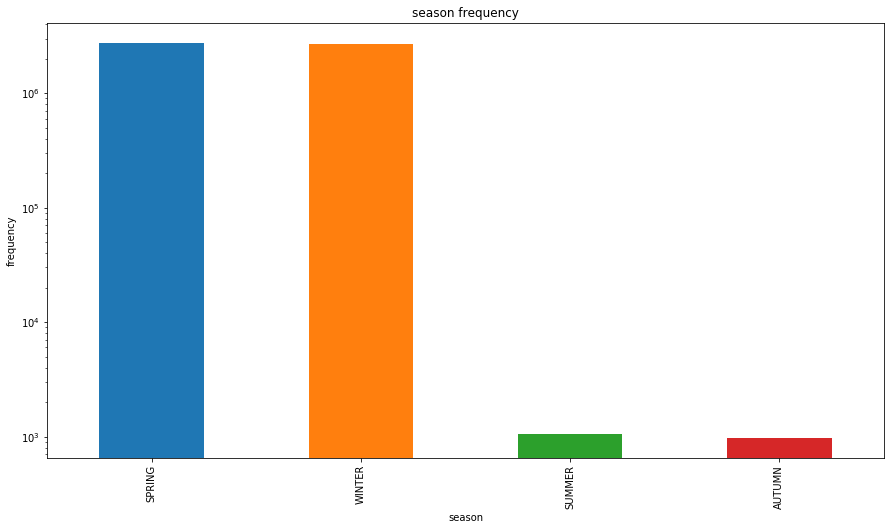

In [57]:
## To plot data first we need to create a data frame 
pdDF = nyc2017_season_ticket_count.toPandas()
## plot to show distribution of ticket counts across different states
plt.clf()
pdDF.plot(x='season',y='frequency_per_year',kind='bar',figsize=(15, 8),legend=None)
plt.xlabel('season')
plt.ylabel('frequency')
plt.yscale('log')
plt.title('season frequency')
plt.show()

In [58]:
## evaulating top 3 violation code across all the seasons

## first grouping the data based on season and Violation Code

nyc2017_season_violation_code_group = spark.sql("SELECT \
                                                     season, \
                                                     `Violation Code`, \
                                                     count(*) as frequency_per_year \
                                            FROM \
                                                     NYC2017 \
                                            GROUP BY \
                                                     season,`Violation Code`")

## creating a sql temp view

nyc2017_season_violation_code_group.createOrReplaceTempView("NYC2017_SEASON_VIOLATION_CODE_GROUP")

                                                
## finally evauluating top3 violation code for each bucket

nyc2017_season_violation_code_top3 = spark.sql("SELECT \
                                                        season,\
                                                        `Violation Code`, \
                                                        frequency_per_year,\
                                                        rank_top3\
                                                FROM ( \
                                                        SELECT \
                                                                season,\
                                                                `Violation Code`, \
                                                                frequency_per_year, \
                                                                dense_rank() OVER(PARTITION BY season \
                                                                        ORDER BY frequency_per_year DESC) AS rank_top3  \
                                                        FROM \
                                                                NYC2017_SEASON_VIOLATION_CODE_GROUP \
                                                    )  \
                                                WHERE rank_top3 <= 3")
                                    
nyc2017_season_violation_code_top3.show()

+------+--------------+------------------+---------+
|season|Violation Code|frequency_per_year|rank_top3|
+------+--------------+------------------+---------+
|WINTER|            21|            373862|        1|
|WINTER|            36|            348240|        2|
|WINTER|            38|            286999|        3|
|SPRING|            21|            393866|        1|
|SPRING|            36|            314525|        2|
|SPRING|            38|            255064|        3|
|SUMMER|            21|               228|        1|
|SUMMER|            46|               219|        2|
|SUMMER|            40|               109|        3|
|AUTUMN|            46|               219|        1|
|AUTUMN|            40|               121|        2|
|AUTUMN|            21|               100|        3|
+------+--------------+------------------+---------+



Top 3 validation codes across each season are mentioned above.

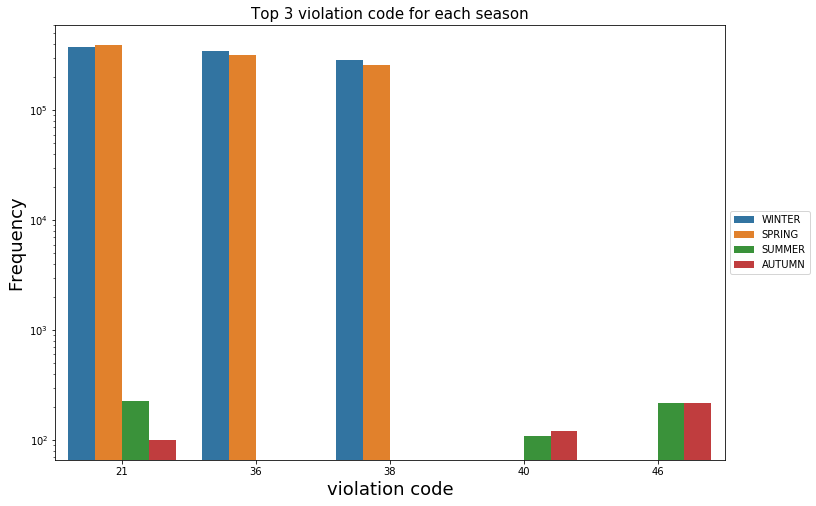

In [59]:
pdDF = nyc2017_season_violation_code_top3.toPandas()
import seaborn as sns
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Violation Code', y='frequency_per_year',hue='season', data=pdDF)
ax.set_ylabel("Frequency", fontsize=18);
ax.set_title('Top 3 violation code for each season',fontsize=15)
ax.set_xlabel("violation code", fontsize=18);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yscale('log')
plt.show()

### The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:

- Find the total occurrences of the three most common violation codes.

- Then, visit the website:

http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page

- It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.

- Using this information, find the total amount collected for the three violation codes with the maximum tickets. State the code that has the highest total collection.

- What can you intuitively infer from these findings?

In [60]:
## Total occurances of top 3 violation codes

## top 3 violation codes are 21, 36, 38

nyc2017_top3_violation_count = nyc2017.filter(col("Violation Code").isin(21,36,38)).groupBy(col("Violation Code")).count()
nyc2017_top3_violation_count.show()

+--------------+------+
|Violation Code| count|
+--------------+------+
|            38|542078|
|            21|768056|
|            36|662765|
+--------------+------+



##### For the top 3 violation codes avrage fine are as below :

- Average fine for Violation code 21 : (65+45)/2  = 55 `$`
- Average fine for Violation code 36 : (50+50)/2  = 50 `$`
- Average fine for Violation code 38 : (65+35)/2  = 50 `$`

In [61]:
## now first we need to enter above information into a new column in dataframe

## average fine amount for violation code 36 and 38 is 50 and average amount for violation code 21 is 55

nyc2017_top3_violation_amount = nyc2017_top3_violation_count.withColumn("Average fine per violation",\
                                                                        when(col("Violation Code")==21,55)
                                                                        .otherwise(50))
nyc2017_top3_violation_amount.show()

+--------------+------+--------------------------+
|Violation Code| count|Average fine per violation|
+--------------+------+--------------------------+
|            38|542078|                        50|
|            21|768056|                        55|
|            36|662765|                        50|
+--------------+------+--------------------------+



In [63]:
## now evaluating the total amount collected

from pyspark.sql.functions import sum

## to get the amount collected for each violation code we need to multiply the average amount collected with the 
## total conunt for each violation code and then we need to to sum up all the product values obtained

nyc2017_total_revenue_top3_violation_code = nyc2017_top3_violation_amount.select(sum(col("count")*\
                                                                                      col("Average fine per violation")))
nyc2017_total_revenue_top3_violation_code.show()

+-----------------------------------------+
|sum((count * Average fine per violation))|
+-----------------------------------------+
|                                102485230|
+-----------------------------------------+



The total revenue from top three violation is $102485230.

We can infer that fine collection for the violations are good source of revenue generation with big amount of $102485230 getting generated from top 3 violations.

# Finish